In [1]:
import torch
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from data_utils import mnist_preparation, add_salt_and_pepper_noise 
from evaluationUtils import calculate_mcm_accuracy
from tqdm import tqdm
import matplotlib as plt
from mcmadaptablemodel import MCMQuantumModel, MCMCircuit
from pennylane import Device
from pennylane.measurements import StateMP
from torch.nn import Module, ParameterDict
import matplotlib.pyplot as plt
from OriginalModel import FullQuantumModel, QuantumCircuit
import warnings
from typing import Optional, Dict, List, Any
from torch.utils.data import DataLoader, dataloader
from time import time
import math
from pennylane.measurements import MidMeasureMP
import pickle
import random
random.seed(42)
torch.manual_seed(1234)

In [2]:
file_names = ['mcm00', 'mcm005', 'mcm01', 'mcm015', 'mcm02', 'mcm025', 'mcm03', 'mcm035']

summaries = {}
tables = {}

directory = "/Users/jackvittori/Desktop/"

for file_name in file_names:
    
    file_path = f"{directory}{file_name}.pickle"
    
    with open(file_path, "rb") as file:
        evaluation_data = pickle.load(file)
    
    summaries[file_name] = evaluation_data['summary']
    tables[file_name] = evaluation_data['table']

print(summaries.keys())
print(tables.keys())

dict_keys(['mcm00', 'mcm005', 'mcm01', 'mcm015', 'mcm02', 'mcm025', 'mcm03', 'mcm035'])
dict_keys(['mcm00', 'mcm005', 'mcm01', 'mcm015', 'mcm02', 'mcm025', 'mcm03', 'mcm035'])


In [20]:
om_accuracy_8 = {
    'mcm00':  0.9303,
    'mcm005': 0.9278,
    'mcm01': 0.9251,
    'mcm015': 0.9012,
    'mcm02': 0.8834,
    'mcm025': 0.8349,
    'mcm03': 0.7157,
    'mcm035': 0.5584}

om_accuracy_4 = {
    'mcm00':  0.8612,
    'mcm005': 0.8569,
    'mcm01': 0.8502,
    'mcm015': 0.8338,
    'mcm02': 0.8217,
    'mcm025': 0.8070,
    'mcm03': 0.7619,
    'mcm035': 0.7137}

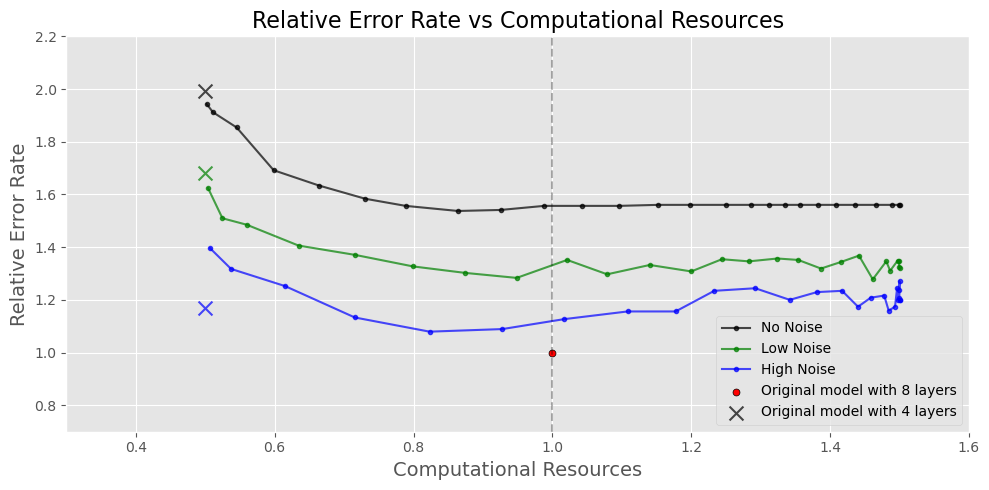

In [31]:
keys = ['mcm00','mcm005','mcm01','mcm015','mcm02','mcm025','mcm03','mcm035']

key0 = keys[0]
key1 = keys[3]
key2 = keys[5]

total_accuracy_0 = summaries[key0]['Total Accuracy']
error_rate_0 = [(1-x)/(1-om_accuracy_8[key0]) for x in total_accuracy_0]
computational_resource_0 = [x/(3714*8) for x in summaries[key0]['Executed layers']]

total_accuracy_1 = summaries[key1]['Total Accuracy']
error_rate_1 = [(1-x)/(1-om_accuracy_8[key1]) for x in total_accuracy_1]
computational_resource_1 = [x/(3714*8) for x in summaries[key1]['Executed layers']]

total_accuracy_2 = summaries[key2]['Total Accuracy']
error_rate_2 = [(1-x)/(1-om_accuracy_8[key2]) for x in total_accuracy_2]
computational_resource_2 = [x/(3714*8) for x in summaries[key2]['Executed layers']]

plt.style.use('ggplot') 
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(computational_resource_0, error_rate_0, marker='.', color='black', alpha=0.7, label='No Noise')
ax.plot(computational_resource_1, error_rate_1, marker='.', color='green', alpha=0.7, label='Low Noise')
ax.plot(computational_resource_2, error_rate_2, marker='.', color='blue', alpha=0.7, label='High Noise')

ax.scatter(1, 1,  marker='.', color='red', edgecolors= 'black', s=100, label='Original model with 8 layers') 
ax.axvline(x = 1, color = 'black', alpha = 0.3, linestyle = '--')

ax.scatter(0.5, (1-om_accuracy_4[key0])/(1-om_accuracy_8[key0]),  marker='x', color='black', alpha=0.7,  s=100, label='Original model with 4 layers')
ax.scatter(0.5, (1-om_accuracy_4[key1])/(1-om_accuracy_8[key1]),  marker='x', color='green', alpha=0.7,  s=100)
ax.scatter(0.5, (1-om_accuracy_4[key2])/(1-om_accuracy_8[key2]),  marker='x', color='blue', alpha=0.7,  s=100)

ax.set_title('Relative Error Rate vs Computational Resources', fontsize=16)
ax.set_xlabel('Computational Resources', fontsize=14)
ax.set_ylabel('Relative Error Rate', fontsize=14)
ax.set_xlim(0.3, 1.6)  # Mostra i tick ogni 5 epochs per ridurre la sovrapposizione
ax.set_ylim(0.7, 2.2)
ax.legend(loc='lower right')

ax.grid(True)
plt.tight_layout()

plt.savefig(f'/Users/jackvittori/Desktop/plots/totalplotclassical.png', dpi=300)
plt.show()

In [ ]:
###############################GRAFICO ACCURACY AL VARIARE DEL NOISE INIZIALE########################################################################################


import matplotlib.pyplot as plt

# Dati
accuracy_class = [0.9230, 0.9180, 0.9130, 0.9040, 0.8834, 0.8349, 0.7157, 0.5584, 0.4348]
accuracy_4 = [0.8612, 0.8559, 0.8502, 0.8338, 0.8217, 0.8007, 0.7619, 0.7037, 0.6542]
class_p = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4]

# Creazione grafico
plt.style.use('ggplot') 
fig, ax = plt.subplots(figsize=(10, 5))

# Titoli e etichette
ax.set_title('Coherent noise conditions', fontsize=16)
ax.set_xlabel('P', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_ylim(0.2, 1)

# Tracciare i punti collegati
ax.plot(class_p, accuracy_class, marker='o', color='b', label='8 layers')
ax.plot(class_p, accuracy_4, marker='o', color='r', label='4 layers')

# Legenda
ax.legend(loc='lower right')

# Griglia e layout
ax.grid(True)
plt.tight_layout()

# Visualizzazione grafico
plt.show()
fig.savefig('/content/drive/MyDrive/QML-early_exit/omcoerentenoise.png', dpi=300)

In [67]:
import matplotlib.pyplot as plt

plt.style.use('ggplot') 
fig, ax = plt.subplots(figsize=(10, 5))

colors = [
    '#4e79a7',  
    '#f28e2b',  
    '#76b7b2',  
    '#e15759',  
    '#59a14f',  
    '#edc948',  
    '#b07aa1',  
    '#ff9da7'   
]

keys = ['mcm00', 'mcm005', 'mcm01', 'mcm015', 'mcm02', 'mcm025', 'mcm03', 'mcm035']

for i, color in enumerate(colors):
    
    total_accuracy = summaries[keys[i]]['Total Accuracy']
    error_rate = [(1 - x) / (1 - om_accuracy_8[keys[i]]) for x in total_accuracy]
    computational_resource = [x / (3714 * 8) for x in summaries[keys[i]]['Executed layers']]
    
    ax.scatter(computational_resource, error_rate, marker='.', color=color, alpha=0.7, edgecolor='black', s=100, label=f'Noise = 0 ({keys[i]})')
    
    ax.scatter(0.5, (1 - om_accuracy_4[keys[i]]) / (1 - om_accuracy_8[keys[i]]), marker='x', color=color, alpha=0.7, s=100, label=f'Original model (4 layers) - {keys[i]}')
    

ax.scatter(1, 1, marker='o', color='r', alpha=0.7, edgecolor='black', s=100, label='Original 8 layer model') 


ax.set_title('Relative error rate vs Computational Resources', fontsize=16)
ax.set_xlabel('Computational resources', fontsize=14)
ax.set_ylabel('Relative Error rate', fontsize=14)
ax.set_xlim(0.3, 1.6)
ax.set_ylim(0.3, 2.2)

#ax.legend(loc='lower right')
ax.grid(True)

plt.tight_layout()

plt.savefig('/Users/jackvittori/Desktop/plots/totalplot.png', dpi=300)
plt.show()

In [122]:
keys = ['mcm00','mcm005','mcm01','mcm015','mcm02','mcm025','mcm03','mcm035']
key = keys[0]

total_accuracy = summaries[key]['Total Accuracy']

computational_resource = [x/(3714*8) for x in summaries[key]['Executed layers']]

plt.style.use('ggplot') 
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(computational_resource, total_accuracy, marker='.', color='black', edgecolor='black', s=100, label='Early exit model')

ax.scatter(1, om_accuracy_8[key],  marker='.', color='r', edgecolor='black', s=100, label='Original model with 8 layers') 
ax.scatter(0.5, om_accuracy_4[key],  marker='.', color='g', edgecolor='black', s=100, label='Original model with 4 layers')
ax.axvline(x=1, color='black', linestyle='--', alpha=0.3)
ax.axhline(y=om_accuracy_4[key], color='black', linestyle='--', alpha=0.3)

ax.set_title('Accuracy vs Computational ', fontsize=16)
ax.set_xlabel('Computational resources', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.set_xlim(0.45, 1.52)  # Mostra i tick ogni 5 epochs per ridurre la sovrapposizione
ax.set_ylim(0.53, 0.95)
ax.legend(loc='lower right')

ax.grid(True)
plt.tight_layout()

plt.savefig(f'/Users/jackvittori/Desktop/plots/accuracy{key}.png', dpi=300)
plt.show()

In [ ]:
§